In [1]:
#imports
try:
    from google.colab import drive
    #mount drive, set base path
    drive.mount("/gdrive")
    base_path = '/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites'
except:
    base_path = '../'
from pathlib import Path
import matplotlib.pyplot as plt
import random
from random import randint, choice

import time

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms

from tqdm.auto import tqdm
import numpy as np
from PIL import Image

import copy

In [2]:
torch.cuda.is_available()

True

In [3]:
#utility functions for:
# setting the seed
# ensuring randomness of worker in data loader (overkill?)
# setting the device based on GPU availability

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [4]:
#dataset paths
#set these paths and file names depending on where you are and which labels you are using

data_path = Path(base_path).joinpath('data/')
train_images_path = Path(data_path).joinpath('training_images_rand4_unique.npy')
train_labels_path = Path(data_path).joinpath('training_objcounts_rand4_unique.npy')
val_images_path = Path(data_path).joinpath('validation_images_rand4_unique.npy')
val_labels_path = Path(data_path).joinpath('validation_objcounts_rand4_unique.npy')

#get image area
train_imgarea_path = Path(data_path).joinpath('training_imgareas_rand4_unique.npy')
val_imgarea_path = Path(data_path).joinpath('validation_imgareas_rand4_unique.npy')

In [5]:
#load the numpy dataset files
train_images = np.load(train_images_path).astype(float)
train_labels = torch.tensor(np.load(train_labels_path).astype(float))
val_images = np.load(val_images_path).astype(float)
val_labels = torch.tensor(np.load(val_labels_path).astype(float))

#load image area files
train_imgarea = np.load(train_imgarea_path).astype(float)
val_imgarea = np.load(val_imgarea_path).astype(float)

In [6]:
# change labels so that they start at 0
# TODO this is only valid for counts - so we need a flag for this or change the generator or dataloader appropriately
train_labels = (train_labels)
val_labels = (val_labels)
print(train_labels, val_labels)

tensor([3., 2., 2.,  ..., 3., 1., 2.], dtype=torch.float64) tensor([2., 1., 3.,  ..., 1., 4., 4.], dtype=torch.float64)


Text(0.5, 1.0, 'object area: tensor(1., dtype=torch.float64)')

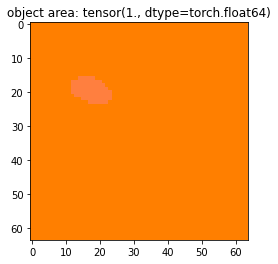

In [7]:
#examine data
idx = np.random.randint(0, train_images.shape[0])
plt.imshow(train_images[idx])
plt.title('object area: ' + str(train_labels[idx]))

## Prepare dataloaders for cnn

In [8]:
#define the dataset class for our data for use by the dataloader
class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, images, labels, transform=None, target_transform=None):
        # assert all(tensors[0].size[0] == tensor.size[0] for tensor in tensors)
        self.images = images
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x = self.images[index]

        if self.transform:
          x = self.transform(x)

        y = self.img_labels[index]
        if self.target_transform:
          y = self.target_transform(y)

        return x.float(), y.float(), index

    def __len__(self):
        return len(self.img_labels)

In [9]:
#instantiate the dataset
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_data =  CustomTensorDataset(train_images, train_labels, transform=train_transform)
val_data = CustomTensorDataset(val_images,val_labels,transform=train_transform)

In [10]:
#instantiate the dataloaders

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()
# Create the corresponding DataLoaders for training and test
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

BATCH_SIZE = 128  # number of examples per minibatch

train_loader = torch.utils.data.DataLoader(train_data,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           num_workers=12,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
val_loader = torch.utils.data.DataLoader(val_data,
                                         shuffle=True,
                                         batch_size=BATCH_SIZE,
                                         num_workers=12,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

Random seed 2021 has been set.
GPU is enabled in this notebook.


## CNN model for regression

In [11]:
# Create a sample network
class conv_net(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = x.squeeze()

        return x

In [12]:
# Create a sample network
class conv_net1(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = x.squeeze()

        return x

In [13]:
# Create a sample network
class conv_net2(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*4*64, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)
        
        # Conv layer 4.
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
#         x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = x.squeeze()

        return x

Training and testing functions

In [14]:
def calc_error(output,target):
    return np.abs(output-target)/target

In [15]:
#define the train and test loops, and a wrapper that will call them to train and collect validation stats

def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
    """
    Trains the current inpur model using the data
    from Train_loader and Updates parameters for a single pass
    """
    device = args['device']
    model.train()
    for batch_idx, (data, target, index) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if reg_function1 is None:
            loss = criterion(output, target)
        elif reg_function2 is None:
            loss = criterion(output, target)+args['lambda']*reg_function1(model)
        else:
            loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
        loss.backward()
        optimizer.step()

    return model


def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
    """
    Tests the current Model
    """
    model.eval()
    test_loss = 0
    perc_error = 0
    
    with torch.no_grad():
        for data, target, index in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            perc_error += np.sum(calc_error(output.cpu().detach().numpy(),target.cpu().detach().numpy()))
    test_loss /= len(test_loader.dataset)
    perc_error /= len(test_loader.dataset)
    return test_loss, perc_error


# def main(args, model, train_loader, val_loader,
#          reg_function1=None, reg_function2=None):
#   """
#   Trains the model with train_loader and tests the learned model using val_loader
#   """

#   device = args['device']

#   model = model.to(device)
#   optimizer = optim.SGD(model.parameters(), lr=args['lr'],
#                         momentum=args['momentum'])

#   val_loss_list, train_loss_list,param_norm_list = [], [], []
#   for epoch in tqdm(range(args['epochs'])):
#     trained_model = train(args, model, train_loader, optimizer,
#                           reg_function1=reg_function1,
#                           reg_function2=reg_function2)
#     train_loss = test(trained_model, train_loader, device=device)
#     val_loss = test(trained_model, val_loader, device=device)
#     print(train_loss, val_loss)
#     # param_norm = calculate_frobenius_norm(trained_model)
#     train_loss_list.append(train_loss)
#     val_loss_list.append(val_loss)
#     # param_norm_list.append(param_norm)

#   return val_acc_list, train_acc_list, trained_model

def early_stopping_main(args, model, train_loader, val_loader, criterion, reg_function1=None, reg_function2=None):
    device = args['device']
    model = model.to(device)
    optimizer = optim.RMSprop(model.parameters(),
                        lr=args['lr'],
                        momentum=args['momentum'])

    best_acc = 10
    best_epoch = 0

    # Number of successive epochs that you want to wait before stopping training process
    patience = 30

    # Keps track of number of epochs during which the val_acc was less than best_acc
    wait = 0

    val_acc_list, train_acc_list, val_error_list, train_error_list = [], [], [], []
    for epoch in tqdm(range(args['epochs'])):

        # train the model
        trained_model = train(args, model, train_loader, optimizer,
                              reg_function1=reg_function1,
                              reg_function2=reg_function2,
                              criterion=criterion)

        # calculate training accuracy
        train_acc, train_perc_error = test(trained_model, train_loader, criterion=criterion, device=device)

        # calculate validation accuracy
        val_acc, val_perc_error = test(trained_model, val_loader, criterion=criterion, device=device)

        if (val_acc < best_acc):
            best_acc = val_acc
            best_epoch = epoch
            best_model = copy.deepcopy(trained_model)
            wait = 0
        else:
            wait += 1

        if (wait > patience):
            print(f'early stopped on epoch: {epoch}')
            break

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_error_list.append(train_perc_error)
        val_error_list.append(val_perc_error)
        print(train_acc, val_acc, train_perc_error, val_perc_error)
    #save the model
    if('checkpoint_path' in args):
        torch.save({
          'model_state_dict': best_model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, args['checkpoint_path'])

    return val_acc_list, train_acc_list, train_error_list, val_error_list, best_model, best_epoch


Random seed 2021 has been set.


1.306120313873291 1.307704366493225 0.3363187504196167 0.3376749612569809
1.0013520874023438 1.0037745294570923 0.29335666564941404 0.29450476131439207
0.5965246719360352 0.6036178615570068 0.2286242706680298 0.2299363757610321
0.6422357074737549 0.649132876777649 0.21958284671783448 0.21837848649024963
1.3823556182861327 1.381996869468689 0.3546284016418457 0.353631033039093
0.48024023307800295 0.4875271335601807 0.18550904092788698 0.1842609085083008
0.5225178559112549 0.5296047100067138 0.19189379615783692 0.19094593503475188
0.7110181085968018 0.717260670375824 0.2445921071624756 0.24419506063461305
0.7932471759033203 0.7996760614395142 0.2502015771865845 0.2501842980861664
0.9071704629516602 0.9098737996101379 0.2924642284011841 0.29106749777793883
0.3329416458511353 0.3412747541427612 0.15226304077148436 0.15252088668346406
0.5282697624969482 0.5351136134624481 0.19702226394653322 0.19595219345092774
0.8563848184204101 0.8609146495819092 0.2775210639953613 0.27624284172058106
0.5

0.16009676900863648 0.18416551532745362 0.09983634582519531 0.10406489839553833
0.11828897212982177 0.14204143272042274 0.10393321702957153 0.11140680758953095
0.11113326664924622 0.13538964722156524 0.0932183427810669 0.10044975934028626
0.16320872568130493 0.18689388065338136 0.10804958847045898 0.11232373185157776
0.09209358639717102 0.11728030546307563 0.09052339184761048 0.0997690075993538
0.09096675395965576 0.11548908228874206 0.0939340884590149 0.10335422750711441
0.1407753060722351 0.16464307565689087 0.09979352655410767 0.10499891527891159
0.1227324931526184 0.14703401839733124 0.09454830018997193 0.10145705010890961
0.12947165055274965 0.15497000048160553 0.09290790756225586 0.09909231927394867
0.1353957019805908 0.15983187670707702 0.09616783338546753 0.1023316418170929
0.16940689182281493 0.19398050961494445 0.10367907587051392 0.10717227792739868
0.224161690864563 0.24821344752311705 0.11774946109771728 0.11923931109905243
0.10200681973457336 0.12747739177942277 0.0851838

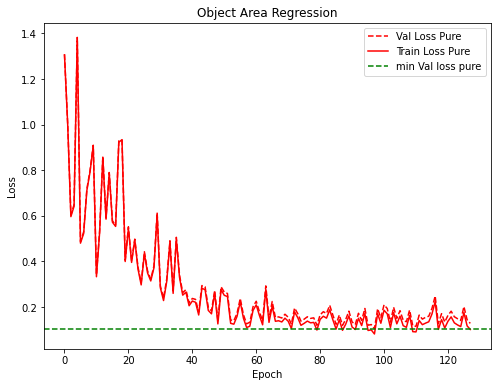

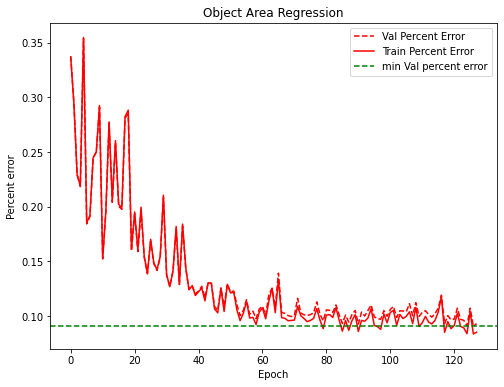

In [16]:
#set the hyper parameters, run the training and plot results
# Set the arguments
args = {
    'epochs': 200,
    'lr': 0.00038413048078536063,
    'momentum': 0.04048300142402773,
    'device': DEVICE,
    'checkpoint_path':'./cnn_reg_objcount_lr0.01_mmt0.8.pt'
}


# Initialize the network
set_seed(seed=SEED)
model = conv_net2()

start_time = time.time()
# Train the network
val_loss_pure, train_loss_pure, train_error_list, val_error_list, model, best_epoch= early_stopping_main(args=args,
                                                            model=model,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=F.mse_loss)
end_time = time.time()

print(f"Time to memorize the dataset: {end_time - start_time}")

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_loss_pure, label='Val Loss Pure', c='red', ls='dashed')
plt.plot(train_loss_pure, label='Train Loss Pure', c='red', ls='solid')
plt.axhline(y=min(val_loss_pure), c='green', ls='dashed',
            label='min Val loss pure')
plt.title('Object Area Regression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_error_list, label='Val Percent Error', c='red', ls='dashed')
plt.plot(train_error_list, label='Train Percent Error', c='red', ls='solid')
plt.axhline(y=min(val_error_list), c='green', ls='dashed',
            label='min Val percent error')
plt.title('Object Area Regression')
plt.ylabel('Percent error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Analyze trained models

In [16]:
model_path = Path(base_path).joinpath('models/')
model1_path = Path(model_path).joinpath('cnn_reg_objarea_lr0.005_mmt0.8.pt')
model2_path = Path(model_path).joinpath('cnn2_reg_objarea_lr0.01_mmt0.8.pt')
model3_path = Path(model_path).joinpath('cnn3_reg_objarea_lr0.01_mmt0.8.pt')
model4_path = Path(model_path).joinpath('cnn3_reg_imgarea_lr0.01_mmt0.8.pt')
model5_path = Path(model_path).joinpath('cnn_reg_objcount_lr0.001_mmt0.8.pt')

In [33]:
model1 = conv_net()
model_state_dict = torch.load(model5_path)['model_state_dict']
model1.load_state_dict(model_state_dict)

<All keys matched successfully>

In [18]:
val_loader = torch.utils.data.DataLoader(val_data,
                                         shuffle=True,
                                         batch_size=200,
                                         num_workers=12,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

In [22]:
data,target,index = next(iter(val_loader))
# data,target = data.to(DEVICE),target.to(DEVICE)

In [23]:
output = model1(data)

Text(0, 0.5, 'predicted object area')

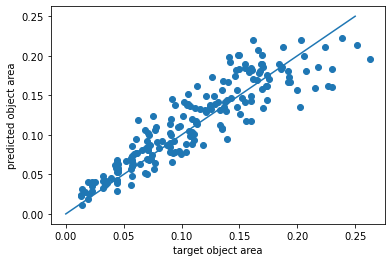

In [24]:
plt.scatter(target.cpu().detach().numpy(),output.cpu().detach().numpy())
plt.plot(np.linspace(0,0.25,10),np.linspace(0,0.25,10))
plt.xlabel('target object area')
plt.ylabel('predicted object area')

In [25]:
perc_occluded = val_imgarea/val_labels.numpy()

Text(0, 0.5, 'Percent error of area estimation')

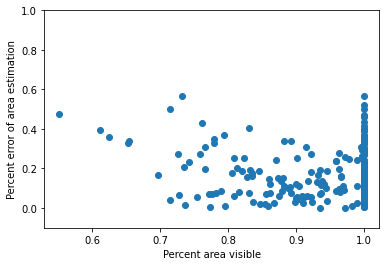

In [27]:
plt.scatter(perc_occluded[index], calc_error(target.cpu().detach().numpy(),output.cpu().detach().numpy()))
# plt.plot(np.linspace(0,0.25,10),np.linspace(0,0.25,10))
plt.ylim(-0.1,1)
plt.xlabel('Percent area visible')
plt.ylabel('Percent error of area estimation')

Text(0, 0.5, 'Predicted area - target area')

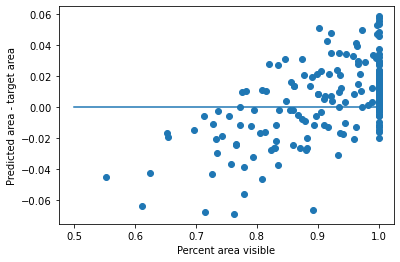

In [29]:
plt.scatter(perc_occluded[index],output.cpu().detach().numpy()- target.cpu().detach().numpy())
plt.plot(np.linspace(0.5,1,10),np.zeros(10))
# plt.ylim(-0.1,1)
plt.xlabel('Percent area visible')
plt.ylabel('Predicted area - target area')

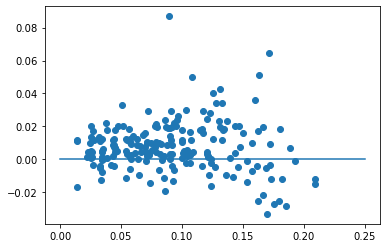

In [29]:
plt.scatter(target.cpu().detach().numpy(), output.cpu().detach().numpy()- target.cpu().detach().numpy())
plt.plot(np.linspace(0,0.25,10),np.zeros(10))
# plt.ylim(-0.1,1)

In [30]:
np.mean(calc_error(target.cpu().detach().numpy(),output.cpu().detach().numpy()))

0.18312347

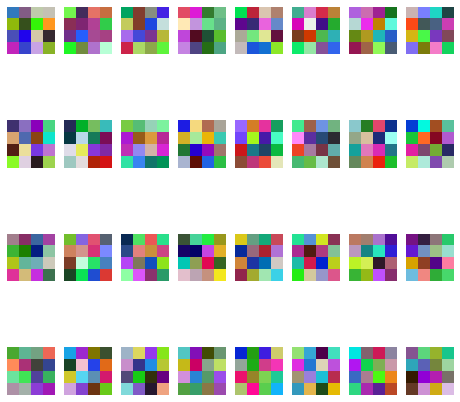

In [31]:
with torch.no_grad():
    conv1_weights = model_state_dict['conv1.weight']
    fig, axs = plt.subplots(4, 8, figsize=(8, 8))
    filters = []
    for filter_index in range(conv1_weights.shape[0]):
        row_index = filter_index // 8
        col_index = filter_index % 8
        
#         idx = np.random.choice(conv1_weights.shape[1],3)
#         print(idx)
        filter = conv1_weights[filter_index,:,:,:]
        filter_image = filter.permute(1, 2, 0).cpu()
        scale = np.abs(filter_image).max()
        scaled_image = filter_image / (2 * scale) + 0.5
        filters.append(scaled_image.cpu())
        axs[row_index, col_index].imshow(scaled_image.cpu())
        axs[row_index, col_index].axis('off')
    plt.show()